# Notebook lecture 8: Stability and Performance Robustness
&copy; 2025 ETH Zurich, Joël Gmür, Joël Lauper, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Authors:
- Joël Gmür; jgmuer@ethz.ch
- Joël Lauper; jlauper@ethz.ch
- Ivan Robuschi, irobuschi@ethz.ch

## Description
This week's Jupyter notebook will include the small-gain theorem, the stability of feedback control schemes, and performance robustness.

To start, run the following cell to install the necessary modules and import the libraries.

In [8]:
!pip install numpy scipy matplotlib ipywidgets control

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
import control as ctrl
from IPython.display import display, clear_output

np.set_printoptions(suppress=True, precision=3)

# Exercise 1: Small Gain Theorem
## Check the Small Gain Theorem condition
This function checks if the loop gain $|\alpha P_1(s) * P_2(s)| < 1$ for all frequencies. We use here a SISO system which is easier regarding stability and pole calculation.

Parameters:
- Amplification $\alpha = 1$
- Transfer function of the system $P_1(s)$
- Transfer function of the feedback $P_2(s)$
    
Returns:
- True if the Small Gain Theorem holds, i.e., system is stable
- False if the Small Gain Theorem does not hold, i.e., system is unstable

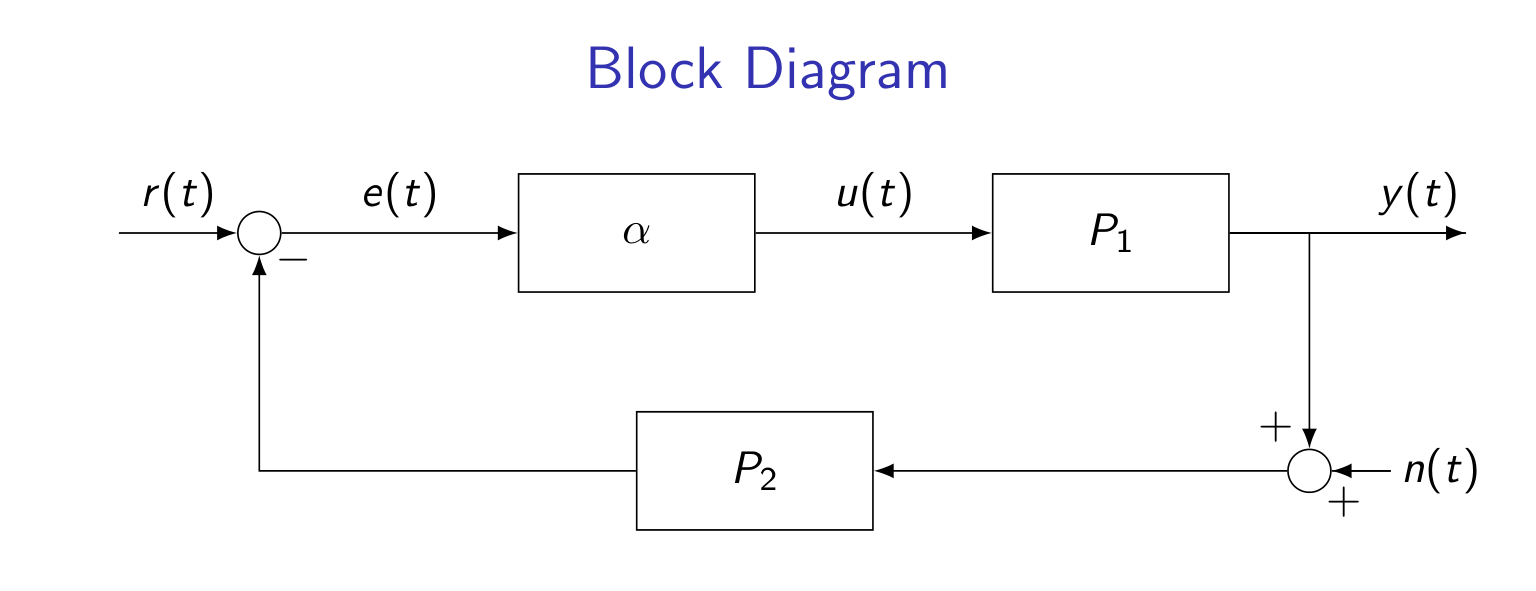

In [10]:
def small_gain_theorem(P1, P2):
    # Check if P1 and P2 are stable
    tolerance=1e-6

    # Create a frequency vector (logarithmic scale for better visualization)
    omega = np.logspace(-2, 2, 1000)  # Frequency range from 0.01 to 100 rad/s

    magnitude_product = np.abs(P1(omega)) * np.abs(P2(omega))

    # Check if the product is less than 1 at all frequencies
    if np.all(magnitude_product < 1 + tolerance):
        return True
    else:
        return False


## Plot the loop gain
This function plots the loop gain $|P_1(s) * P_2(s)|$ in dB.

Below an example is shown which checks the small gain theorem and then plots the loop gain. Remember: We can only use the small gain theorem if $P_1$ and $P_2$ are stable.

The interconnected system does not satisfy the Small Gain Theorem and may be unstable.


c:\Users\joell\anaconda3\Lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


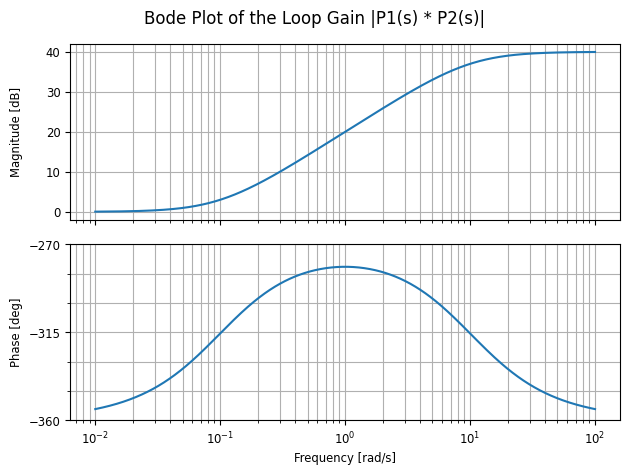

In [11]:
def check_stability(P):
    # Get the poles of the transfer function
    poles = ctrl.poles(P)  # Correct method is `ctrl.poles(P)`

    # Check if any pole has a positive real part (right half-plane)
    for pole in poles:
        if pole.real > 0:
            return False  # System is unstable
    return True  # System is stable

def plot_gain(P1, P2):
    omega = np.logspace(-2, 2, 1000)
    loop_gain = P1 * P2
    _, mag_dB, _ = ctrl.bode(loop_gain, omega, dB=True, plot=True)

    plt.suptitle("Bode Plot of the Loop Gain |P1(s) * P2(s)|")
    plt.show()

# P1(s) = (20s + 1) / (s + 20) (example of a plant, high gain at high frequencies)
P1 = ctrl.TransferFunction([10, 1], [1, 10])

# P2(s) = 0.1 (proportional controller)
P2 = ctrl.TransferFunction([10], [1])


# Test Small Gain Theorem
stability = small_gain_theorem(P1, P2)

if check_stability(P1) and check_stability(P2):
    if stability:
        print("The interconnected system satisfies the Small Gain Theorem and is stable.")
    else:
        print("The interconnected system does not satisfy the Small Gain Theorem and may be unstable.")
else:
    print("P1 and/or P2 is/are unstable.")

# Plot the loop gain
plot_gain(P1, P2)

As we can see, our combination of $P_1$ and $P_2$ violates the small gain theorem and we do not know if the interconnection is stable. If we change our function $P_2$ from a proportional controller to a low pass filter, we suppress the high frequencies gain. Then, the small gain theorem holds and gives us a sufficient condition for a stable interconnection of $P_1$ and $P_2$.

The interconnected system satisfies the Small Gain Theorem and is stable.


c:\Users\joell\anaconda3\Lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


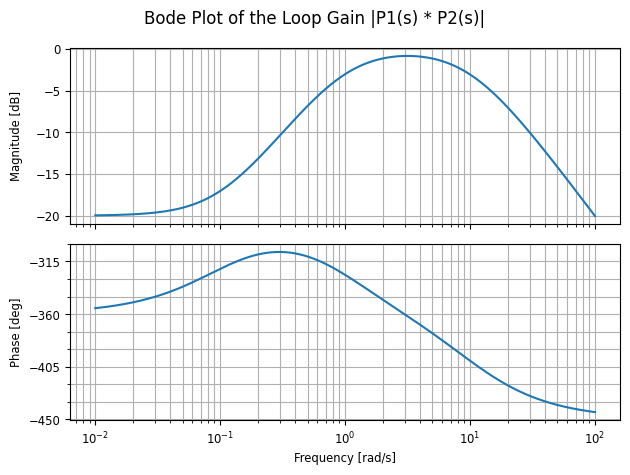

In [12]:
#same function as above but P2 is changed


# P1(s) = (20s + 1) / (s + 20) (example of a plant, high gain at high frequencies)
P1 = ctrl.TransferFunction([10, 1], [1, 10])

# P2(s) = 1 / (s + 1) (NEW! low pass filter)
P2 = ctrl.TransferFunction([1], [1, 1])


# Test Small Gain Theorem
stability = small_gain_theorem(P1, P2)

if check_stability(P1) and check_stability(P2):
    if stability:
        print("The interconnected system satisfies the Small Gain Theorem and is stable.")
    else:
        print("The interconnected system does not satisfy the Small Gain Theorem and may be unstable.")
else:
    print("P1 and/or P2 is/are unstable.")

# Plot the loop gain
plot_gain(P1, P2)

## Exercise 2 - System response in presence of disturbances

This exercise has the objective of showing the importance of keeping disturbances in mind during control synthesis.

This time, you are tasked to design the speed controller of a conveyor belt in a package shipping center, as the one in the picture below.

The system is subject to considerable disturbances as the load varies in an unpredictable fashion, however, the speed of the conveyor belt itself needs to be kept constant.

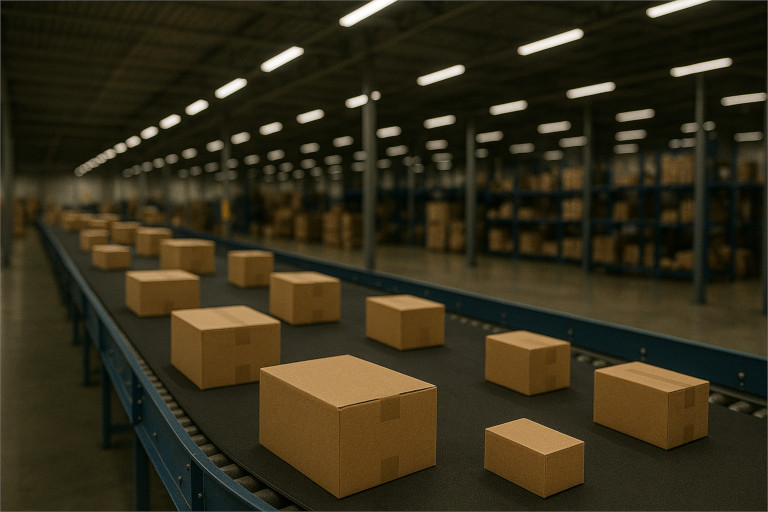

The block diagram can be seen below.

For the sake of the exercise, we model the conveyor belt simplistically as a low-pass filter with transfer function $P(s)=\frac{2}{0.75s+1}$.

To control the system we choose a PI controller with transfer function $C(s)=k_p+\frac{1}{k_i}$.

The disturbance $\Delta (t)$ is modeled as a piecewise constant signal and simulates repeated loading and unloading of the conveyor belt. $W(s)$ is chosen to be a constant scaling factor that models the weight of the individual loads.



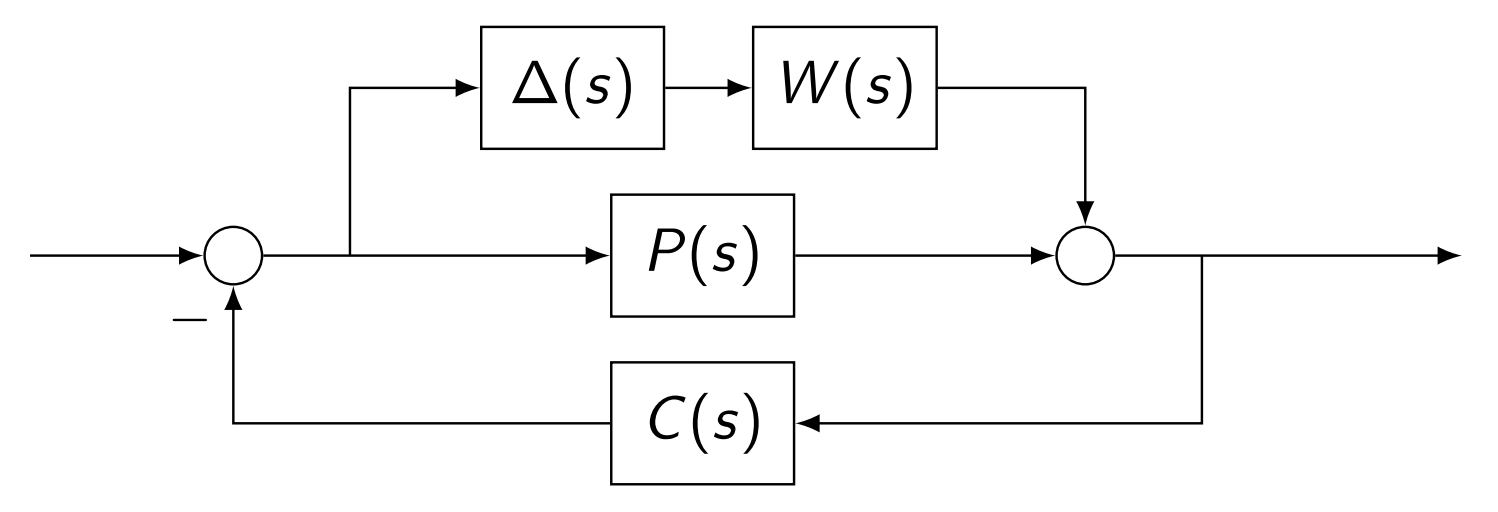

For this exercise, execute the script below and move the sliders.
Your task is the following:

1. Start with $W=0$. Try to tune a controller to the following rough specifications for its step response:

- Zero steady-state error;
- No significant overshoot;
- 95% of the target speed reached within 2s;
- As little aggressive as you can.


2. Introduce the additive disturbance by setting $W>0$. Is the controller from before still acceptable?

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from control import tf, feedback, forced_response, step_response
import ipywidgets as widgets
from IPython.display import display

# Define the time vector from 0 to 30 seconds.
t = np.linspace(0, 30, 3000)

# Define the fixed disturbance signal δ(t) as a piecewise function.
def disturbance_signal(t):
    d = np.zeros_like(t)
    # 0 to 2 s: no disturbance
    # 2 to 7 s: light package added (0.5)
    d[(t >= 2) & (t < 7)] = 0.5
    # 7 to 10 s: package removed
    d[(t >= 7) & (t < 10)] = 0.0
    # 10 to 13 s: heavy package added (1.0)
    d[(t >= 10) & (t < 13)] = 1.0
    # 13 to 18 s: an additional light package added (total 1.3)
    d[(t >= 13) & (t < 18)] = 1.3
    # 18 to 20 s: heavy package removed (back to 0.3)
    d[(t >= 18) & (t < 20)] = 0.3
    # 20 to 25 s: another package added (total 1.1)
    d[(t >= 20) & (t < 25)] = 1.1
    # 25 to 30 s: all packages removed (0)
    d[(t >= 25)] = 0.0
    # Normalize so that the infinity norm is 1
    if np.linalg.norm(d, np.inf) > 0:
        d = d / np.linalg.norm(d, np.inf)
    return d

# Get the normalized disturbance signal δ(t)
delta = disturbance_signal(t)


# Define the nominal plant P(s) = 2/(0.75s + 1)
def get_nominal_system():
    s = tf([1, 0], [1])
    P = 2 / (0.75 * s + 1)
    return P

# Define the PI controller: C(s) = Kp + Ki/s
def get_PI_controller(Kp, Ki):
    s = tf([1, 0], [1])
    C = Kp + Ki/s
    return C


# Function to update the plots given the slider values.
def update_plots(Kp, Ki, W):
    P = get_nominal_system()
    C = get_PI_controller(Kp, Ki)

    # Closed-loop transfer function from reference to output:
    # T(s) = [C(s)*P(s)] / [1 + C(s)*P(s)]
    T = feedback(C * P, 1)

    # Sensitivity function from disturbance to output:
    # S(s) = P(s) / [1 + C(s)*P(s)]
    S = P / (1 + C * P)

    # Simulate the closed-loop step response (reference = 1)
    t_ref, y_ref = step_response(T, t)

    # Simulate the response to the disturbance: disturbance input = W * δ(t)
    disturbance = W * delta
    t_dist, y_dist = forced_response(S, t, disturbance)

    # Total output is the superposition (by linearity) of the two responses:
    y_total = y_ref + y_dist

    # Now, compute the control input u(t)
    # Error is: e(t) = r(t) - y_total(t) where r(t)=1
    e = 1 - y_total
    # Control input is: u(t) = C(s)*e(t)
    t_u, u = forced_response(C, t, e)

    # Create 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Subplot 1: Scaled disturbance signal, W * δ(t), plus unscaled disturbance dashed.
    axs[0].plot(t, disturbance, 'r', linewidth=2, label='Scaled Disturbance')
    axs[0].plot(t, delta, 'k--', linewidth=1, label='Unscaled Disturbance')
    axs[0].set_title('Disturbance Signal')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Disturbance')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Closed-loop system response to a unit step reference with disturbance.
    axs[1].plot(t, y_total, 'b', linewidth=2, label='Total Output')
    axs[1].plot(t, y_ref, 'g--', linewidth=1, label='Response to Step Reference')
    # Draw the reference as a dashed orange line (reference = 1)
    axs[1].plot(t, np.ones_like(t), color='orange', linestyle='--', linewidth=1, label='Reference')
    axs[1].set_title('Closed-Loop Step Response with Disturbance')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Output')
    axs[1].legend()
    axs[1].grid(True)

    # Subplot 3: Control input u(t)
    axs[2].plot(t_u, u, 'm', linewidth=2)
    axs[2].set_title('Control Input u(t)')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('u(t)')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

# Create interactive sliders for Kp, Ki, and W.
Kp_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1.0, description='Kp')
Ki_slider = widgets.FloatSlider(min=0.0, max=5, step=0.1, value=0, description='Ki')
W_slider  = widgets.FloatSlider(min=0.0, max=3, step=0.1, value=0, description='W')

# Create the interactive output.
widgets.interact(update_plots, Kp=Kp_slider, Ki=Ki_slider, W=W_slider)


interactive(children=(FloatSlider(value=1.0, description='Kp', max=5.0, min=0.1), FloatSlider(value=0.0, descr…

<function __main__.update_plots(Kp, Ki, W)>

## Explanation

### No disturbance
As you might remember from CS I, we need the integrator $k_i$ to eliminate the steady-state error. MAke sure to choose $k_p$ as high as needed to reach the target speed fast enough. At the same time, it shouldn't be higher than needed to ensure a no significant overshoot and low aggressivity.

### Disturbance included
Our goal of rejecting the disturbance matches mathematically speaking the robust stability problem. The figure shows an **additive uncertainty**. If the $H$-infinity norm (maximum singular value) of our disturbance $\| \Delta_1 \|_{H_\infty} < 1$ we can conclude that our system is robustly stable if and only if our plant fulfills the same condition (see lecture): $\| G(s) \|_{H_\infty} < 1$. Here, we do it manually and we see that the disturbance has a high influence! Our controller needs to be faster (higher $k_p$) to deal with it.

Qualitatively, it can be seen that a large disturbance makes it almost impossible to get a nice output.